# Evaluation Notebook for Concentric Circles Experiments

F.X. Vialard and R. Kwitt and S. Wei and M. Niethammer    
**A Shooting Formulation of Deep Learning**    
*NeurIPS 2020*

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.collections as mcoll
import matplotlib.path as mpath
from matplotlib.colors import LinearSegmentedColormap
import pickle

import seaborn as sns
sns.set()
sns.set_style("white")

import sys
sys.path.append('../../')

import numpy as np
from collections import defaultdict
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import neuro_shooting
from neuro_shooting.shooting_models import AutoShootingIntegrandModelUpDown as UpDown
from neuro_shooting.shooting_models import AutoShootingIntegrandModelDampenedUpDown as UpDownDamp
from neuro_shooting.shooting_models import AutoShootingIntegrandModelSimple as Simple
from neuro_shooting.shooting_models import AutoShootingIntegrandModelSecondOrder as SecOrder
from neuro_shooting.shooting_blocks import ShootingBlockBase as Base
import neuro_shooting.parameter_initialization as pi

from utils import ConcentricSphere, dataset_to_numpy, sample
from cc import Model

Generate some testing data ...

In [2]:
data_dim = 2

test_data = ConcentricSphere(data_dim, 
                             inner_range=(0., .5), 
                             outer_range=(1., 1.5), 
                             num_points_inner=1000, 
                             num_points_outer=2000)

test_loader = DataLoader(test_data, 
                         batch_size=64, 
                         shuffle=False)

Let's plot the testing data ...

In [3]:
def plot_data(X, y):
    plt.figure(figsize=(6,6))
    plt.plot(X[np.where(y==0)[0],0], X[np.where(y==0)[0],1],'.', color='red',  label='0', alpha=0.5)
    plt.plot(X[np.where(y==1)[0],0], X[np.where(y==1)[0],1],'.', color='blue', label='1', alpha=0.5)
    plt.axis('equal');
    plt.legend();

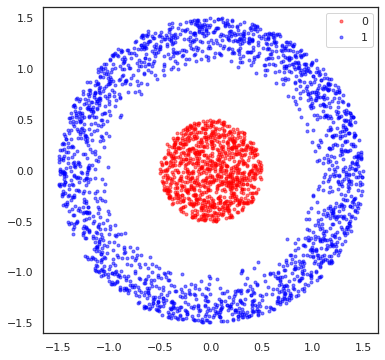

In [4]:
test_data_np, test_targets_np = dataset_to_numpy(test_loader)
plot_data(test_data_np, test_targets_np)

Next are some visualization routines for debugging purposes.

In [5]:
def particle_viz(tracker, fname, epoch=-1):
    
    fig = plt.figure(figsize=(3,3))
    ax = fig.gca()
    for axis in ['top','bottom','left', 'right']:
        ax.spines[axis].set_linewidth(3)
        ax.spines[axis].set_color("black")

    assert len(tracker) > 0 and (epoch < len(tracker) or epoch == -1)
    assert isinstance(tracker[-1], defaultdict)
    
    t_org = tracker[epoch]['t']
    t_idx = np.argsort(t_org)
    
    for p_id in range(tracker[epoch]['q1'][0].size(0)):
        p = np.vstack([tracker[epoch]['q1'][t][p_id].cpu().squeeze().numpy() for t in t_idx])
        ax.plot(p[: ,0],p[:, 1], '-', lw=3)
        ax.plot(p[-1,0],p[-1,1], '.', color='black')
        #ax.plot(p[0, 0],p[0, 1], '.', color='red')
    ax.grid(False)
    ax.tick_params(axis='both', which='both', bottom=False, top=False,
                    labelbottom=False, right=False, left=False,
                    labelleft=False)
    #plt.savefig(fname, bbox_inches='tight', pad_inches=0)

In [6]:
def layer_stats(tracker, quantity, epoch=-1):
    from numpy.linalg import svd

    plt.figure(figsize=(4,2))
    plt.title('Layer {} stats from [0,1]'.format(quantity))
    assert len(tracker) > 0 and (epoch < len(tracker) or epoch == -1)
    assert isinstance(tracker[-1], defaultdict)
    
    t_org = tracker[epoch]['t']
    t_idx = np.argsort(t_org)
    
    stats = defaultdict(list)
    for t in t_idx: 
        U,S,V = svd(tracker[epoch][quantity][t])
        stats['nuc'].append(np.max(S)) # Lipschitz constant
        stats['fro'].append(tracker[epoch][quantity][t].norm().item())
    
    plt.plot(np.array(t_org)[t_idx], stats['nuc'], label='Nuc.', lw=3)
    plt.plot(np.array(t_org)[t_idx], stats['fro'], label='Fro.', lw=3)
    plt.legend()
    plt.xlabel('Time')
    plt.grid()

In [7]:
def plot_trajectory(model, data, N, fname):
    sample_ds = sample(data, N)
    sample_dl = DataLoader(sample_ds, batch_size=32, shuffle=False)
    
    trajectory_X = []
    trajectory_y = []

    for data, target in sample_dl:
        out,_,_,_ = model.trajectory(data.unsqueeze(1), 50)
        trajectory_X.append(out.detach().cpu())
        trajectory_y.append(target.detach().cpu())    
    trajectory_X = torch.cat(trajectory_X,dim=1).numpy()
    trajectory_y = torch.cat(trajectory_y,dim=0).numpy()
    
    alpha = 0.5

    fig = plt.figure(figsize=(3,3))
    ax = fig.gca()
    for axis in ['top','bottom','left', 'right']:
        ax.spines[axis].set_linewidth(3)
        ax.spines[axis].set_color("black")
    
    
    for i in range(trajectory_y.shape[0]):
        r = trajectory_X[:,i,::].squeeze()
        c = 'red' if trajectory_y[i,0]==0 else 'blue'
        ax.scatter(r[-1,0],r[-1,1],color=c, alpha=alpha, s=5)
        ax.plot(r[:,0],r[:,1],'-', color=c, alpha=alpha, lw=1)
    ax.axis('equal');
    #plt.title('Trajectories', fontsize=12)
    ax.grid(False)
    ax.tick_params(axis='both', which='both', bottom=False, top=False,
                    labelbottom=False, right=False, left=False,
                    labelleft=False)
    #plt.savefig(fname, bbox_inches='tight', pad_inches=0)


In [8]:
def input_space_plt(model):
    cm = plt.cm.RdBu

    x_min, x_max = -2, 2
    y_min, y_max = -2, 2 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    data = torch.tensor(np.c_[
        xx.ravel(), 
        yy.ravel()], dtype=torch.float32).unsqueeze(1)
    model.eval()
    _, predictions = model(data)
    
    colors = [(1, 1, 1), (0, 0, 1), (0.5, 0, 0.5), (1, 0, 0), (1, 1, 1)]
    colors.reverse()
    colormap = LinearSegmentedColormap.from_list('cmap_red_blue', colors, N=300)
    zz = predictions.detach().numpy().reshape(xx.shape)
    
    plt.figure(figsize=(4,4))
    plt.imshow(zz, cmap=colormap, alpha=0.75)
    plt.title('Decision boundary', fontsize=12)
    plt.grid(False)
    plt.axis('equal')

## Statistics

Here, we load the results of all models (over 10 random initializations) and check how many times the model perfectly fit to the data. We evaluate this for two **inflation factors** ($\alpha$), 5 and 20.

In [9]:
models = {5:  'concentric_circles_runs/model_5_run_{}_results_.pkl',
          20: 'concentric_circles_runs/model_20_run_{}_results_.pkl'}

random_inits = range(1,11)

for alpha,m in models.items():
    sep = 0
    for r in random_inits:
        with open(m.format(r), 'rb') as fid:
            res = pickle.load(fid)
            #print(res[1][-1][2])
            if np.abs(res[1][-1][2] - 100.0) < 1.0:
                sep += 1
                
    print('inflation: {:02d} | {:.2f} [%]'.format(
        alpha,
        float(sep)/len(list(random_inits))*100.0))

inflation: 05 | 10.00 [%]
inflation: 20 | 90.00 [%]


## Visualizations

In [13]:
import pickle
import glob

def show(name, prefix):
    with open('concentric_circles_runs/' + name + '.pkl', 'rb') as f: 
        args, tracker = pickle.load(f)
    model = torch.load('concentric_circles_runs/' + name + '.pt')
    print('#Parameters', np.sum([p.numel() for p in model.parameters()]))
    plot_trajectory(model, test_data, 100, prefix + 'trajectory.pdf')    
    #particle_viz(tracker, prefix + 'particle.pdf')
    #layer_stats(tracker, 'l1_weight')
    #layer_stats(tracker, 'l2_weight')

Below we visualize the trajectory of the points in the 2D input space for two models, one with $\alpha=5$ and one with $\alpha=20$.

#Parameters 1686
#Parameters 486


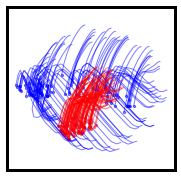

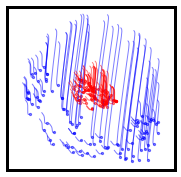

In [14]:
show('model_20_run_4', '')
show('model_5_run_4',  '')

As we can see (more clearly from the stats above), the model trained with $\alpha=20$ (top) can clearly separate the data, while the model trained with $\alpha=5$ can not.